# Perform Classification on the ADNI dataset using SVMs, after FAMD

## Importing Stuff:

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import numpy as np
import warnings
import sys 
import os
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = ('ignore::UserWarning,ignore::ConvergenceWarning,ignore::RuntimeWarning')
import pickle
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import GridSearchCV

## Read the data:

The transformed through LR data is located at "./DATA/Linearly_Transformed_Unique_Dataset.pkl".

The transformed through FAMD data is located at "./DATA/FAMD_Transformed_data_10_components.pkl"

In [43]:
# Read the data transformed through the Regressional Analysis:
lr_data = pd.read_pickle("./DATA/Linearly_Transformed_Unique_Dataset.pkl")
print(lr_data.shape)
lr_data.head()

(1302, 209)


,PTID,MRID,Date,Age,Sex,DLICV_baseline,APOE4_Alleles,APOE_Genotype,Diagnosis_nearest_2.0,MUSE_Volume_4,...,rs111278892,rs3752246,rs4147929,rs41289512,rs3865444,rs6024870,rs6014724,rs7274581,rs429358,Diagnosis_nearest_2.0_cat
0,002_S_0295,002_S_0295_2006-04-18,2006-04-18,84.742466,0,1485405.375,1.0,E3/E4,CN,-401.428503,...,1,1,1,0,0,0,0,0,1,0
9,002_S_0413,002_S_0413_2006-05-02,2006-05-02,76.283562,1,1364116.000,0.0,E3/E3,CN,596.355045,...,0,1,1,0,1,0,0,0,0,0
24,002_S_0559,002_S_0559_2006-05-23,2006-05-23,79.223288,0,1570479.625,1.0,E3/E4,CN,224.874560,...,0,0,0,0,1,0,0,0,0,0
31,002_S_0619,002_S_0619_2006-06-01,2006-06-01,77.447945,0,1859348.250,2.0,E4/E4,Dementia,2633.277779,...,0,0,0,1,1,0,0,0,2,1
45,002_S_0729,002_S_0729_2006-07-17,2006-07-17,65.056164,1,1166961.750,1.0,E3/E4,MCI,256.289641,...,0,0,0,1,1,0,0,0,1,2


In [44]:
famd_data = pd.read_pickle("./DATA/FAMD_Transformed_data_10_components.pkl")
print(famd_data.shape)
famd_data.head()

(1302, 10)


,Component 0,Component 1,Component 2,Component 3,Component 4,Component 5,Component 6,Component 7,Component 8,Component 9
0,-0.458537,1.191976,0.213234,-0.454051,-0.646684,0.025220,-0.733883,0.115547,-0.835330,0.574247
1,-0.623830,0.435098,0.432188,0.921615,-0.061815,0.192108,-0.853644,-0.521925,-0.301022,-0.636971
2,-0.727419,1.577828,-0.132211,-1.184806,-0.352358,-0.620869,-0.197984,-0.522243,-0.109195,-0.619681
3,2.069125,-1.895185,-0.676591,0.890941,0.657846,0.214591,-0.293011,-0.089317,0.440440,-0.184255
4,0.702825,0.594687,0.033435,-0.222714,-0.138131,-0.446616,-0.789827,-0.452877,-0.142894,-0.573783


### Create the Dataset:

In [50]:
# Create a new dataset and drop the imaging and genetic data:
c = list(lr_data.columns)
MRI_columns = c[c.index("MUSE_Volume_4"):c.index("MUSE_Volume_207")+1]
genetic_columns = c[c.index("rs4575098"):c.index("rs429358")+1]
columns_to_drop = MRI_columns + genetic_columns
famd = lr_data.drop(labels = columns_to_drop, axis=1)
famd.reset_index(drop=True, inplace=True)

# Embed them into the new dataset:
component_labels = ["component_"+str(x+1) for x in range(famd_data.shape[1])] 
famd[component_labels] = famd_data
print(famd.shape)
famd.head()

(1302, 20)


,PTID,MRID,Date,Age,Sex,DLICV_baseline,APOE4_Alleles,APOE_Genotype,Diagnosis_nearest_2.0,Diagnosis_nearest_2.0_cat,component_1,component_2,component_3,component_4,component_5,component_6,component_7,component_8,component_9,component_10
0,002_S_0295,002_S_0295_2006-04-18,2006-04-18,84.742466,0,1485405.375,1.0,E3/E4,CN,0,-0.458537,1.191976,0.213234,-0.454051,-0.646684,0.025220,-0.733883,0.115547,-0.835330,0.574247
1,002_S_0413,002_S_0413_2006-05-02,2006-05-02,76.283562,1,1364116.000,0.0,E3/E3,CN,0,-0.623830,0.435098,0.432188,0.921615,-0.061815,0.192108,-0.853644,-0.521925,-0.301022,-0.636971
2,002_S_0559,002_S_0559_2006-05-23,2006-05-23,79.223288,0,1570479.625,1.0,E3/E4,CN,0,-0.727419,1.577828,-0.132211,-1.184806,-0.352358,-0.620869,-0.197984,-0.522243,-0.109195,-0.619681
3,002_S_0619,002_S_0619_2006-06-01,2006-06-01,77.447945,0,1859348.250,2.0,E4/E4,Dementia,1,2.069125,-1.895185,-0.676591,0.890941,0.657846,0.214591,-0.293011,-0.089317,0.440440,-0.184255
4,002_S_0729,002_S_0729_2006-07-17,2006-07-17,65.056164,1,1166961.750,1.0,E3/E4,MCI,2,0.702825,0.594687,0.033435,-0.222714,-0.138131,-0.446616,-0.789827,-0.452877,-0.142894,-0.573783


## Perform Classification using SVMs:

In [52]:
def perform_svm(X,Y,kern= None, model=svm.LinearSVC(), params=None):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.8, shuffle=False)
    
    
    clf = GridSearchCV(model, params, n_jobs=-1, cv=10)
    clf.fit(X_train,Y_train)
    print("Best Parameters for untrained data (",kern," kernel):",clf.best_params_)
    pred =  clf.predict(X_test)
    acc = accuracy_score(Y_test, pred)
    f1 = f1_score(Y_test, pred, average='weighted')
    cm = confusion_matrix(Y_test, pred, normalize='true')
    bal_acc = balanced_accuracy_score(Y_test, pred)
    if kern == None:
        print('Accuracy (Linear Kernel): ', "%.2f" % (acc*100))
        print('Balanced Accuracy (Linear Kernel): ', "%.2f" % (bal_acc*100))
        print('F1 (Linear Kernel): ', "%.2f" % (f1*100))
    else:
        print('Accuracy ('+kern+' Kernel): ', "%.2f" % (acc*100))
        print('Balanced Accuracy ('+kern+' Kernel): ', "%.2f" % (bal_acc*100))
        print('F1 ('+kern+' Kernel): ', "%.2f" % (f1*100))       
    return acc, f1, np.around(cm, decimals=2), bal_acc

In [53]:
Accuracies = []
F1s = []
Balanced_Accuracies = []
# LinearSVC: one-vs-the-rest scheme.
# SVC: one-vs-one scheme.

l, p, r = svm.LinearSVC(dual=False,max_iter=2000), svm.SVC(), svm.SVC()
l_params = {'C':[0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10]}
p_params = {'C':[0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10],
            'degree':[2,3,4,5],
            'coef0':[0.0,10.0,100.0,1000.0],
            'gamma': [0.0001, 0.001, 0.01, 0.1, 1]}
r_params = {'C': [0.00001, 0.001, 0.01, 0.1, 1, 10], 
            'gamma': [0.0001, 0.001, 0.01, 0.1, 1]}

    
# Get the values that interest us:
X = famd[component_labels]
Y = famd["Diagnosis_nearest_2.0_cat"]

# Create 3 separate kernels for experimentation (increase max_iter because of warning):

lin_accuracy, lin_f1, lin_cm, lin_bal_acc= perform_svm(X,Y, kern='linear', model=l, params=l_params)
poly_accuracy, poly_f1, poly_cm, poly_bal_acc = perform_svm(X,Y,kern='poly', model=p, params=p_params)
rbf_accuracy, rbf_f1, rbf_cm, rbf_bal_acc = perform_svm(X,Y,kern='rbf', model=r, params=r_params)

Accuracies += lin_accuracy, poly_accuracy, rbf_accuracy
F1s += lin_f1, poly_f1, rbf_f1
Balanced_Accuracies += lin_bal_acc, poly_bal_acc, rbf_bal_acc


names = ['Linear', 'Poly', 'RBF']

max_acc = np.argmax(Accuracies)
print("Model with max Accuracy: ", names[max_acc], " with an Accuracy score of ", round(max(Accuracies)*100,3))
max_f1 = np.argmax(F1s)
print("Model with max F1 Score: ", names[max_f1], " with an F1 Score of ", round(max(F1s)*100,3))
max_bal_acc = np.argmax(Balanced_Accuracies)
print("Model with max Balanced Accuracy Score: ", names[max_bal_acc], " with a Balanced Accuracy Score of ", round(max(Balanced_Accuracies)*100,3))

Best Parameters for untrained data ( linear  kernel): {'C': 0.01}
Accuracy (linear Kernel):  54.41
Balanced Accuracy (linear Kernel):  45.82
F1 (linear Kernel):  52.05
Best Parameters for untrained data ( poly  kernel): {'C': 10, 'coef0': 0.0, 'degree': 2, 'gamma': 0.01}
Accuracy (poly Kernel):  55.17
Balanced Accuracy (poly Kernel):  44.42
F1 (poly Kernel):  50.87
Best Parameters for untrained data ( rbf  kernel): {'C': 10, 'gamma': 0.01}
Accuracy (rbf Kernel):  55.17
Balanced Accuracy (rbf Kernel):  44.42
F1 (rbf Kernel):  50.87
Model with max Accuracy:  Poly  with an Accuracy score of  55.172
Model with max F1 Score:  Linear  with an F1 Score of  52.046
Model with max Balanced Accuracy Score:  Linear  with a Balanced Accuracy Score of  45.816


### Visualise the results:

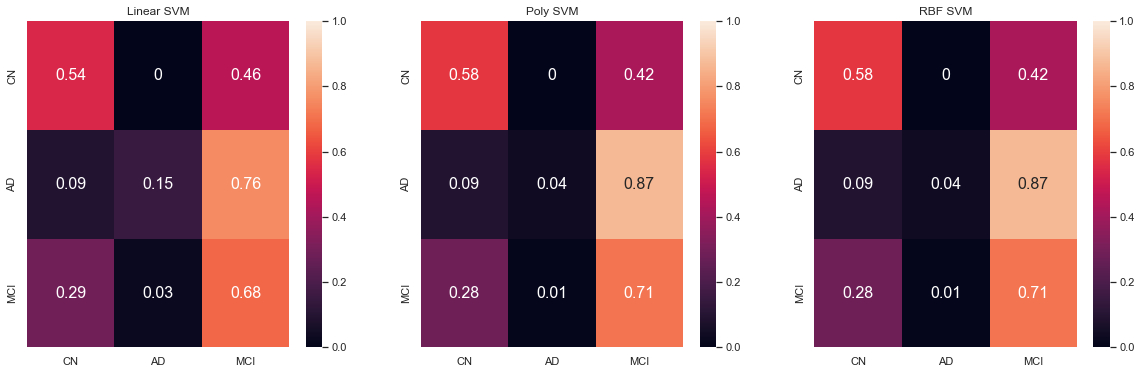

Invalid -W option ignored: unknown warning category: 'ConvergenceWarning'
Invalid -W option ignored: unknown warning category: 'ConvergenceWarning'
Invalid -W option ignored: unknown warning category: 'ConvergenceWarning'
Invalid -W option ignored: unknown warning category: 'ConvergenceWarning'
Invalid -W option ignored: unknown warning category: 'ConvergenceWarning'
Invalid -W option ignored: unknown warning category: 'ConvergenceWarning'
Invalid -W option ignored: unknown warning category: 'ConvergenceWarning'
Invalid -W option ignored: unknown warning category: 'ConvergenceWarning'


In [54]:
fig, axes = plt.subplots(nrows=1,ncols=3,figsize=(20,6));
sns.set(font_scale=1) # for label size
sns.heatmap(lin_cm, vmin=0.0, vmax=1.0, annot=True, annot_kws={"size": 16}, ax = axes[0], fmt='g',
           xticklabels = ["CN", "AD", "MCI"], yticklabels = ["CN", "AD", "MCI"]).set_title("Linear SVM")
sns.heatmap(poly_cm, vmin=0.0, vmax=1.0, annot=True, annot_kws={"size": 16}, ax = axes[1], fmt='g',
           xticklabels = ["CN", "AD", "MCI"], yticklabels = ["CN", "AD", "MCI"]).set_title("Poly SVM")
sns.heatmap(rbf_cm, vmin=0.0, vmax=1.0, annot=True, annot_kws={"size": 16}, ax = axes[2], fmt='g',
           xticklabels = ["CN", "AD", "MCI"], yticklabels = ["CN", "AD", "MCI"]).set_title("RBF SVM")
plt.show()

## Try with balancing and scaling:

In [56]:
# Scaling the data I think is not needed since they are relatively low and close values:
famd.describe()
# # Scale the data:
# scaler = preprocessing.StandardScaler()
# scaler.fit(famd)
# famd_scaled = scaler.transform(famd)
# famd = famd_scaled

,Age,Sex,DLICV_baseline,APOE4_Alleles,Diagnosis_nearest_2.0_cat,component_1,component_2,component_3,component_4,component_5,component_6,component_7,component_8,component_9,component_10
count,1302.000000,1302.000000,1.302000e+03,1302.000000,1302.000000,1302.000000,1.302000e+03,1.302000e+03,1.302000e+03,1.302000e+03,1.302000e+03,1.302000e+03,1.302000e+03,1.302000e+03,1.302000e+03
mean,74.844016,0.430876,1.430945e+06,0.566820,1.148233,0.000000,1.364329e-17,5.116235e-17,-8.049543e-17,3.410823e-18,8.663491e-17,-3.547256e-17,-4.229421e-17,-5.457317e-18,9.550306e-18
std,5.128754,0.495389,1.416305e+05,0.657065,0.889943,1.009895,6.716754e-01,5.752846e-01,5.623934e-01,5.449354e-01,5.426921e-01,5.304187e-01,5.230405e-01,5.177396e-01,5.058516e-01
min,65.004110,0.000000,1.057343e+06,0.000000,0.000000,-3.329491,-2.348283e+00,-1.552190e+00,-1.643465e+00,-1.594890e+00,-1.441188e+00,-1.643589e+00,-1.471003e+00,-1.483467e+00,-1.825194e+00
25%,70.865068,0.000000,1.329192e+06,0.000000,0.000000,-0.707919,-4.162079e-01,-4.292971e-01,-3.790728e-01,-4.046949e-01,-4.015995e-01,-3.765798e-01,-3.696663e-01,-3.637446e-01,-2.914826e-01
50%,74.549315,0.000000,1.429595e+06,0.000000,1.000000,-0.099467,1.320473e-02,7.128689e-02,-1.563678e-02,-7.137572e-02,-7.279833e-03,-1.219697e-02,8.317085e-03,-5.037200e-03,1.209884e-02
75%,78.853767,1.000000,1.528250e+06,1.000000,2.000000,0.652276,4.198680e-01,4.018236e-01,3.860367e-01,3.205693e-01,3.980115e-01,3.605045e-01,3.660548e-01,3.772886e-01,2.975712e-01
max,84.958904,1.000000,1.859348e+06,2.000000,2.000000,3.951490,2.667404e+00,1.778368e+00,1.928750e+00,1.821646e+00,1.490988e+00,1.611511e+00,1.579898e+00,2.316430e+00,2.527583e+00


In [57]:
# Balance the data through Undersampling - Use the same indexes as the LR Data:
print(famd['Diagnosis_nearest_2.0'].value_counts())
famd.head(10)

MCI         626
CN          433
Dementia    243
Name: Diagnosis_nearest_2.0, dtype: int64


,PTID,MRID,Date,Age,Sex,DLICV_baseline,APOE4_Alleles,APOE_Genotype,Diagnosis_nearest_2.0,Diagnosis_nearest_2.0_cat,component_1,component_2,component_3,component_4,component_5,component_6,component_7,component_8,component_9,component_10
0,002_S_0295,002_S_0295_2006-04-18,2006-04-18,84.742466,0,1485405.375,1.0,E3/E4,CN,0,-0.458537,1.191976,0.213234,-0.454051,-0.646684,0.025220,-0.733883,0.115547,-0.835330,0.574247
1,002_S_0413,002_S_0413_2006-05-02,2006-05-02,76.283562,1,1364116.000,0.0,E3/E3,CN,0,-0.623830,0.435098,0.432188,0.921615,-0.061815,0.192108,-0.853644,-0.521925,-0.301022,-0.636971
2,002_S_0559,002_S_0559_2006-05-23,2006-05-23,79.223288,0,1570479.625,1.0,E3/E4,CN,0,-0.727419,1.577828,-0.132211,-1.184806,-0.352358,-0.620869,-0.197984,-0.522243,-0.109195,-0.619681
3,002_S_0619,002_S_0619_2006-06-01,2006-06-01,77.447945,0,1859348.250,2.0,E4/E4,Dementia,1,2.069125,-1.895185,-0.676591,0.890941,0.657846,0.214591,-0.293011,-0.089317,0.440440,-0.184255
4,002_S_0729,002_S_0729_2006-07-17,2006-07-17,65.056164,1,1166961.750,1.0,E3/E4,MCI,2,0.702825,0.594687,0.033435,-0.222714,-0.138131,-0.446616,-0.789827,-0.452877,-0.142894,-0.573783
5,002_S_0816,002_S_0816_2006-08-30,2006-08-30,70.767123,0,1444128.125,2.0,E4/E4,Dementia,1,-0.025197,0.784484,0.569990,0.349782,0.358887,0.134957,-1.295141,0.411843,-0.246943,0.233085
6,002_S_0938,002_S_0938_2006-10-05,2006-10-05,82.167123,1,1309685.000,0.0,E3/E3,Dementia,1,0.832319,-0.005456,-0.448042,-0.055115,0.277745,-0.422737,-0.450299,0.912097,-0.764983,-0.391803
7,002_S_0954,002_S_0954_2006-10-10,2006-10-10,69.198630,1,1075661.500,1.0,E3/E4,MCI,2,1.525645,2.108083,0.355435,-0.670840,-0.383287,-0.267532,0.278076,0.580789,0.030999,0.721951
8,002_S_0955,002_S_0955_2006-10-11,2006-10-11,78.161644,1,1363607.000,1.0,E3/E4,Dementia,1,1.013918,1.521335,-0.474216,0.778926,0.579028,0.204679,-0.709356,0.642515,-0.118708,-0.249882
9,002_S_1018,002_S_1018_2006-11-29,2006-11-29,70.658904,1,1355603.000,0.0,E3/E3,Dementia,1,0.710075,0.633281,0.552380,-0.009782,-0.698400,0.081649,0.668254,0.441816,-0.057136,-0.008292
